In [8]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# # Load the JSON file
# with open('reddit_data/reddit_submissions.json', 'r') as f:
#     data = json.load(f)

# submissions = data['submissions']

# # Create DataFrame from the submissions data
# df = pd.DataFrame(submissions)

# df = df[["id", "author", "created_utc", "title", "selftext", "score", "upvote_ratio", "num_comments", "num_crossposts", "url"]]

# df.to_csv("reduced_reddit_posts.csv", index=False)

df = pd.read_csv("patient_posts.csv")
df = df.dropna(subset=['Content', 'Title'])
df


,Author,Datetime,Title,Content
0,Emis_Moderator,2014-12-01T12:07+00:00,Menopause resources,Below are various resources for Menopause from...
1,jayneejay,2014-08-04T10:21+00:00,66 Peri menopause / Menopause Symptoms you may...,SIXTY-SIX PHYSICAL SYMPTOMS: Part one 1 - 49 T...
2,vivian72668,2023-05-01T20:12+00:00,Voodoo Doll Syndrome: Is someone pricking me w...,Hey Ladies... Have you ever felt as if someone...
3,vivian72668,2024-03-02T16:20+00:00,"PRE-MENOPAUSE: Ladies, who were you before MEN...","Hello There, Lovely Ladies Who were you, befor..."
4,vivian72668,2024-02-28T19:14+00:00,POST-MENOPAUSAL Nervous Bladder: Anyone Else?,"Hey Ladies... For the past week and a half, my..."
...,...,...,...,...
11644,Guest,2006-01-23T12:47+00:00,Hi all I started in the Menopause 2 years ago ...,Click here to view image [i:2e514660aa]This me...
11645,Guest,2005-12-18T11:35+00:00,"Hi all, I was interested in your experiences. ...","Hi all, I was interested in your experiences. ..."
11646,Guest,2006-01-05T05:17+00:00,I have recently been prescribed Livial as an i...,I have recently been prescribed Livial as an i...
11647,Guest,2006-07-04T21:14+00:00,I have been very interested to read other user...,I have been very interested to read other user...


In [9]:
# def epoch_to_date(epoch_time):
#     """
#     Convert epoch time to datetime object with only year, month, and day.

#     :param epoch_time: Epoch time in seconds
#     :type epoch_time: int or float
#     :return: Date string in the format 'YYYY-MM-DD'
#     :rtype: str
#     """
#     dt = datetime.fromtimestamp(epoch_time)
#     return dt.strftime('%Y-%m-%d')

# df["created_utc"] = df["created_utc"].apply(epoch_to_date)

In [10]:
# extract age information
def extract_age(text):
    # Regular expression pattern to extract age information
    age_pattern = r"(?:\b(?:I\s*am|I'?m|am|I'?m\s*at|she'?s|she\s*is|age|aged|turn|turning|turned|early|mid|late)\b\s*(\d{2})\s*(?:years?\s*old|yrs?\s*old|y/o|s|yo|f)?\b|\b(\d{2})\s*(?:years?\s*old|yrs?\s*old|y/o|f)\b)"
    match = re.findall(age_pattern, text, re.IGNORECASE)
    if match:
        maximum = int(max(max(match)))

        if maximum < 15 or maximum > 85:
            return None

        return maximum
    else:
        return None


df['title_age'] = df['Title'].apply(lambda x: extract_age(x) if pd.notnull(x) else None)
df['content_age'] = df['Content'].apply(lambda x: extract_age(x) if pd.notnull(x) else None)

# Compare age information from title and selftext, take the larger value
def choose_age(row):
    if pd.notnull(row['title_age']) and pd.notnull(row['content_age']):
        return max(row['title_age'], row['content_age'])
    elif pd.notnull(row['title_age']):
        return row['title_age']
    elif pd.notnull(row['content_age']):
        return row['content_age']
    else:
        return None

# Create 'age' column with the larger age value from title or selftext
df['age'] = df.apply(choose_age, axis=1)

# Drop intermediate columns
df.drop(['title_age', 'content_age'], axis=1, inplace=True)

df["age"] = df["age"].fillna(np.nan)


In [11]:
def find_perimenopause(text):

    if not (isinstance(text,str)):
        print(text)

    # Define the regex pattern to search for perimenopause and postmenopause mentions
    menopause_pattern = r'\b((peri|pre)[- ]?(menop(ausal|ause))?)\b'
    
    # Find all matches of the pattern in the text
    match = re.search(menopause_pattern, text, re.IGNORECASE)

    
    return bool(match)


df['perimenopause'] = df['Content'].apply(find_perimenopause) | df['Title'].apply(find_perimenopause)


In [12]:
def find_postmenopause(text):

    # Define the regex pattern to search for perimenopause and postmenopause mentions
    menopause_pattern = r'\b((post)[- ]?(menop(ausal|ause))|after\s+men(?:opause)?)\b|hyster'
    
    # Find all matches of the pattern in the text
    match = re.search(menopause_pattern, text, re.IGNORECASE)
    
    return bool(match)

def check_both_menopause(row):
    if row['perimenopause'] and row['postmenopause']:
        row['perimenopause'] = False
    return row

df['postmenopause'] = df['Content'].apply(find_postmenopause) | df["Title"].apply(find_postmenopause)
df = df.apply(check_both_menopause, axis=1)

In [13]:
def find_menopause_mention(text):
    match = re.search(r"menopause", text, re.IGNORECASE)

    return bool(match)

def check_postmenopause(row):
    if row['postmenopause']:
        row["menopause_transition"] = False
    return row

df["menopause_transition"] = df["Content"].apply(find_menopause_mention) | df["Title"].apply(find_menopause_mention)
df = df.apply(check_postmenopause, axis=1)

In [14]:
# hot flashes or night sweats
def search_hot_flashes(text):
    # Regular expression pattern to search for variations of hot flashes
    hot_flashes_pattern = r'\b(?:hot\s*flashes?|hot\s*flash?|flash|flashes|hot|sweat|sweating|sweats|heat)'
    match = re.search(hot_flashes_pattern, text, re.IGNORECASE)
    if match:
        return True
    else:
        return False

df['hot_flashes'] = df['Title'].apply(search_hot_flashes) | df['Content'].apply(search_hot_flashes)

In [15]:
def search_night_sweats(text):
    night_sweats_pattern = r"\bnight\s*sweats?"
    match = re.search(night_sweats_pattern, text, re.IGNORECASE)
    return bool(match)

df["night_sweats"] = df['Title'].apply(search_night_sweats) | df['Content'].apply(search_night_sweats)


In [16]:
# sleeping issues, insomnia
def sleep_disorder(text):
    pattern = r'sleep(?:ing)?|insomni(?:a|ac)'
    
    # Search for the pattern in the text
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["sleep_disorder"] = df['Content'].apply(sleep_disorder) | df["Title"].apply(sleep_disorder)

In [17]:
# Search for mentions of depression
def depression(text):
    
    # Define the regex pattern to search for mentions of depression
    pattern = r'\bdepres'
    
    # Search for the pattern in the text
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["depression"] = df['Content'].apply(depression) | df["Title"].apply(depression)

In [18]:
# Search for mentions of anxiety
def anxiety(text):
    
    # Define the regex pattern to search for mentions of anxiety
    pattern = r'\banxi'
    
    # Search for the pattern in the text
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["anxiety"] = df['Content'].apply(anxiety) | df["Title"].apply(anxiety)

In [19]:
# Search for mentions of mood problems
def mood(text):
    
    # Define the regex pattern to search for mentions of anxiety
    pattern = r'\bmood|rage|raging|bitch|suici|emotion'
    
    # Search for the pattern in the text
    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["mood_problems"] = df['Content'].apply(mood) | df["Title"].apply(mood)

In [20]:
def sexual_activity(text):
    pattern = r'\bsex|orgasm|libido'

     # Search for the pattern in the text
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["sexual_problems"] = df['Content'].apply(sexual_activity) | df["Title"].apply(sexual_activity)

In [21]:
def vaginal_dryness(text):
    vag_pattern = r'\bvagin'
    dry_pattern = r'\bdry|burn|itch|irrit'
     # Search for the pattern in the text
    
    # Return True if any match is found, else False
    return bool(re.search(vag_pattern, text, re.IGNORECASE) and re.search(dry_pattern, text, re.IGNORECASE))

df["vaginal_dryness"] = df['Content'].apply(vaginal_dryness) | df["Title"].apply(vaginal_dryness)

In [22]:
def aches_pains(text):
    pattern = r"\bpain|ach|hurt|joint|arthri"

    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["aches_and_pains"] = df['Content'].apply(aches_pains) | df["Title"].apply(aches_pains)    

In [23]:
def skin_problems(text):
    pattern = r'\bskin|acne|sag|wrinkle'

    return bool(re.search(pattern, text, re.IGNORECASE))

df["skin_problems"] = df['Content'].apply(skin_problems) | df["Title"].apply(skin_problems)

In [24]:
def bladder_control_problems(text):
    pattern = r"\bpee|bladder|urine"

    return bool(re.search(pattern, text, re.IGNORECASE))

df["bladder_control_problems"] = df['Content'].apply(bladder_control_problems) | df["Title"].apply(bladder_control_problems)

In [25]:
def heavy_irregular_periods(text):
    # Define the regex pattern to search for "period" and "heavy" in any order
    period_pattern = r"\bperiod|bleed|bled|blood|cycle|clot"
    period_match = re.search(period_pattern, text, re.IGNORECASE)
    
    # heavy_irreg_pattern = r"\bheav|irreg"
    # heavy_irreg_match = re.search(heavy_irreg_pattern, text, re.IGNORECASE)
    # Check if the pattern is found in the text

    return bool(period_match)

df["heavy/irregular_periods"] = df["Content"].apply(heavy_irregular_periods) | df["Title"].apply(heavy_irregular_periods)

In [26]:
def brain_fog(text):
    pattern = r"\bbrain\s*fog|forget"

    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["brain_fog"] = df['Content'].apply(brain_fog) | df["Title"].apply(brain_fog)

In [27]:
def weight_gain(text):
    pattern = r"\bweight"

    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["weight_gain"] = df['Content'].apply(weight_gain) | df["Title"].apply(weight_gain)

In [28]:
def hormone(text):
    pattern = r"\b(patch|dhea|hrt|estrace|estradiol|estro|estriol|progesterone|testo|steroid|hormone\s*repl|hormone\s*thera)"

    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)
df["hormone_therapy"] = df['Content'].apply(hormone) | df["Title"].apply(hormone)

In [29]:
def antidepressants(text):
    pattern = r"\b(anti)[- ]?(depress)|ssri|snri|zoloft|prozac|paxil|paroxen|pexeva|celexa|lexapro|Cymbalta|Drizalma|effexor|Pristiq|fetzima|venlafax"

    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)
df["antidepressants"] = df['Content'].apply(antidepressants) | df["Title"].apply(antidepressants)

In [30]:
def anticonvulsants(text):
    pattern = r"\b(anti)[- ]?(convul|epilep|seiz)|gabapentin|gralise|neurontin|horizant"
    matches = re.findall(pattern, text, re.IGNORECASE)
    return bool(matches)

df["anticonvulsants"] = df['Content'].apply(anticonvulsants) | df["Title"].apply(anticonvulsants)

In [31]:
def estradiol(text):
    pattern = r"\b(estro|estriol|estra)"
    matches = re.findall(pattern, text, re.IGNORECASE)
    return bool(matches)

df["estradiol"] = df['Content'].apply(estradiol) | df["Title"].apply(estradiol)

In [32]:
def progestin(text):
    pattern = r"\b(proges|drospirenone)"
    return bool(re.search(pattern, text, re.IGNORECASE))

df["progestin"] = df['Content'].apply(progestin) | df["Title"].apply(progestin)

In [33]:
def nk3(text):
    pattern = r"\b(feozline|nk3|neurokinin)"
    return bool(re.search(pattern, text, re.IGNORECASE))

df["nk3"] = df['Content'].apply(nk3) | df["Title"].apply(nk3)

In [34]:
def vitamins(text):
    pattern = r"\bvitamin"

    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)
df["vitamins"] = df['Content'].apply(vitamins) | df["Title"].apply(vitamins)

In [35]:
def exercise(text):
    pattern = r"\bexerci"

    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)
df["exercise"] = df['Content'].apply(exercise) | df["Title"].apply(exercise)

heavy/irregular_periods     4777
aches_and_pains             4458
anxiety                     3001
hot_flashes                 2171
sleep_disorder              1531
mood_problems               1156
depression                   970
skin_problems                740
weight_gain                  640
night_sweats                 413
sexual_problems              400
bladder_control_problems     363
brain_fog                    341
vaginal_dryness              158
dtype: object


/var/folders/t4/wdfv31vd0s5cfyh9tw80_2lw0000gn/T/ipykernel_1481/2007686886.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=true_counts_sorted.index, x=true_counts_sorted.values, palette='pastel')


Text(0, 0.5, 'Symptom')

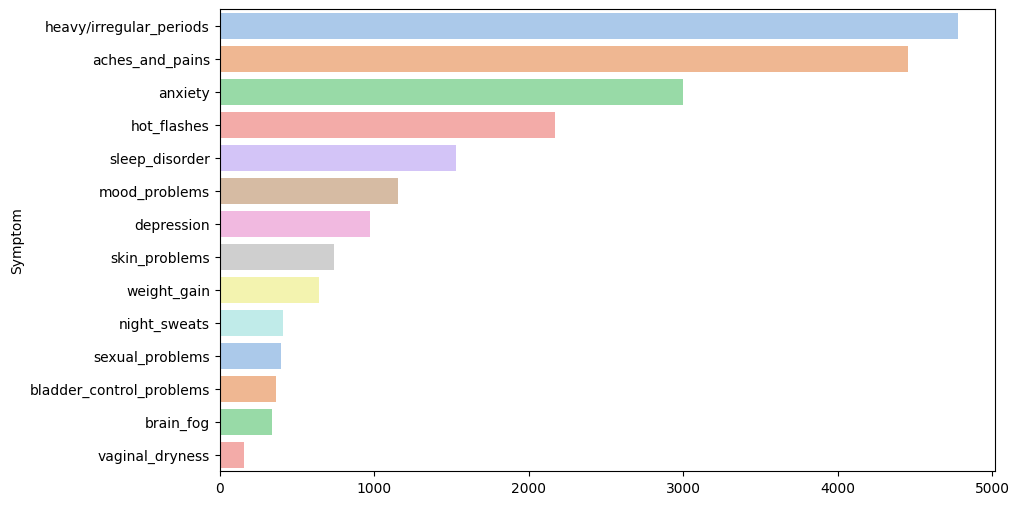

In [36]:
# Frequency of symptoms
symptoms = df.loc[:,'hot_flashes':"weight_gain"]
true_counts = symptoms[symptoms].sum()
true_counts_sorted = true_counts.sort_values(ascending=False)
print(true_counts_sorted)

plt.figure(figsize=(10, 6))
sns.barplot(y=true_counts_sorted.index, x=true_counts_sorted.values, palette='pastel')
plt.ylabel("Symptom")

Index(['Author', 'Datetime', 'Title', 'Content', 'age', 'perimenopause',
       'postmenopause', 'menopause_transition', 'hot_flashes', 'night_sweats',
       'sleep_disorder', 'depression', 'anxiety', 'mood_problems',
       'sexual_problems', 'vaginal_dryness', 'aches_and_pains',
       'skin_problems', 'bladder_control_problems', 'heavy/irregular_periods',
       'brain_fog', 'weight_gain', 'hormone_therapy', 'antidepressants',
       'anticonvulsants', 'estradiol', 'progestin', 'nk3', 'vitamins',
       'exercise'],
      dtype='object')


/var/folders/t4/wdfv31vd0s5cfyh9tw80_2lw0000gn/T/ipykernel_1481/4215441848.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=medication_counts.index, x=medication_counts.values, palette='pastel')


Text(0, 0.5, 'medication')

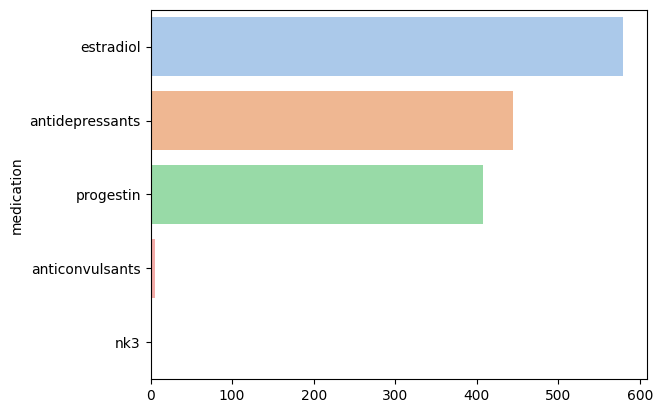

In [37]:
print(df.columns)
medications = df.loc[:,"antidepressants":"nk3"]
medication_counts = medications[medications].sum().sort_values(ascending=False)

sns.barplot(y=medication_counts.index, x=medication_counts.values, palette='pastel')
plt.ylabel("medication")

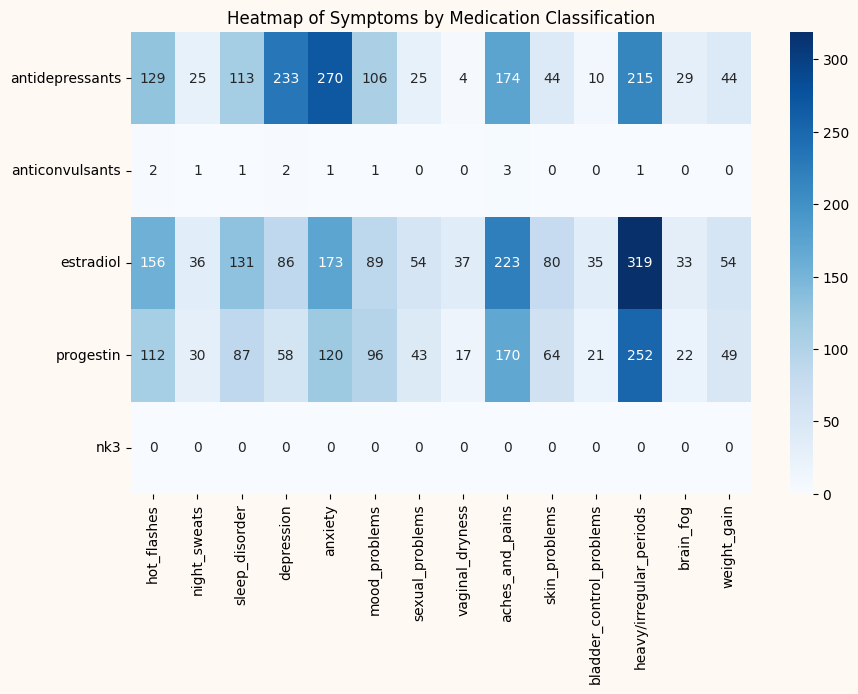

In [38]:
med_columns = ['antidepressants',
       'anticonvulsants', 'estradiol', 'progestin', 'nk3']

# List of symptom columns
symptom_columns = ['hot_flashes', 'night_sweats',
       'sleep_disorder', 'depression', 'anxiety', 'mood_problems',
       'sexual_problems', 'vaginal_dryness', 'aches_and_pains',
       'skin_problems', 'bladder_control_problems', 'heavy/irregular_periods',
       'brain_fog', 'weight_gain']

# Create an empty DataFrame for heatmap data
heatmap_data = pd.DataFrame(0, index=med_columns, columns=symptom_columns)

for med_col in med_columns:
    for symptom_col in symptom_columns:
        heatmap_data.at[med_col,
                        symptom_col] = df[df[med_col] == True][symptom_col].sum()

plt.figure(figsize=(10, 6))

sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='g')
plt.title('Heatmap of Symptoms by Medication Classification')
plt.gcf().set_facecolor('#fff9f4')
plt.savefig("reddit_heatmap.png")